# Kidney CT Scan Dataset: Multimodal Patch-Based GNN for Normal, Cyst, Tumor, and Stone Classification

## Project Description

This project leverages a curated dataset of kidney CT scans collected from multiple diagnostic centers in Dhaka, Bangladesh. The images are categorized into four diagnostic classes:

- **Normal**
- **Cyst**
- **Tumor**
- **Stone**

The primary objective is to implement a **Graph Neural Network (GNN)** model that integrates both **visual features** from the images and **semantic features** derived from medical text to improve classification of kidney conditions.

### Multimodal Design

Each image is divided into smaller patches (e.g., a 4x4 grid). These patches are:
- Processed through a **Convolutional Neural Network (CNN)**, specifically a pretrained **ResNet18**, to extract deep features from each patch.
- Treated as individual **nodes** in a graph, capturing spatial and text-interconnected relationships.

Additionally, each image is paired with a corresponding **domain-informed text description**, such as:
> “Contrast-enhanced CT shows a solid irregular renal mass indicating a tumor.”

These text descriptions are embedded using language models like **BioBERT** or **CLIP**, and included as **text nodes** in the same graph structure.

The resulting graph per image contains:
- **Patch nodes** (image regions)
- **One text node**
- **Edges** representing spatial proximity and semantic relationships

A GNN model (e.g., **Graph Attention Network (GAT)** or **GraphSAGE**) processes this structure to learn complex interactions between image regions and associated diagnostic language, followed by a **global pooling layer** and **multi-layer perceptron (MLP)** for final classification.


## Class Descriptions

- **Normal**: CT scans displaying healthy kidney tissues without visible abnormalities. These serve as a reference baseline.

- **Cyst**: CT images revealing fluid-filled sacs, typically benign, but clinically relevant due to potential complications such as rupture or infection.

- **Tumor**: Scans showing irregular masses that may indicate malignancies like renal cell carcinoma. Tumors are characterized by their shape, density, and contrast uptake.

- **Stone**: Highly radiodense structures representing calcified mineral deposits in the renal system. These may cause pain, obstructions, or urinary tract infections.


## Significance

This multimodal GNN approach demonstrates how **spatial, semantic, and visual information** can be combined to advance automated kidney disease diagnosis. It has the potential to:
- Improve detection accuracy
- Assist radiologists with clinical decision-making
- Serve as a foundation for computer-aided detection (CAD) systems in medical imaging


## 1. Dataset Preparation

In [ ]:
import pandas as pd
import os

csv_path = r"C:\Users\glori\Desktop\Fundamentals of Big Data Analytics\GNN Multimodal analysis\dataset_with_text.csv"

df = pd.read_csv(csv_path)
print("✅ Dataset loaded.")
print(df.head())

✅ Dataset loaded.
   Unnamed: 0       image_id  \
0           0  Tumor- (1044)   
1           1    Tumor- (83)   
2           2   Tumor- (580)   
3           3  Tumor- (1701)   
4           4  Tumor- (1220)   

                                                path   diag  target  Class  \
0  C:\Users\glori\Desktop\Fundamentals of Big Dat...  Tumor       3  Tumor   
1  C:\Users\glori\Desktop\Fundamentals of Big Dat...  Tumor       3  Tumor   
2  C:\Users\glori\Desktop\Fundamentals of Big Dat...  Tumor       3  Tumor   
3  C:\Users\glori\Desktop\Fundamentals of Big Dat...  Tumor       3  Tumor   
4  C:\Users\glori\Desktop\Fundamentals of Big Dat...  Tumor       3  Tumor   

                                    text_description  
0  Contrast-enhanced CT shows a solid irregular r...  
1  Contrast-enhanced CT shows a solid irregular r...  
2  Contrast-enhanced CT shows a solid irregular r...  
3  Contrast-enhanced CT shows a solid irregular r...  
4  Contrast-enhanced CT shows a solid irregul

In [ ]:
df['path_exists'] = df['path'].apply(lambda x: os.path.exists(x))

missing_count = (~df['path_exists']).sum()
if missing_count > 0:
    print(f"{missing_count} images have broken paths.")
    print(df[df['path_exists'] == False][['image_id', 'path']].head())
else:
    print("✅ All image paths are valid.")

✅ All image paths are valid.


## Patch-Based CNN Feature Extraction (ResNet18)

- load each image

- Divide the images into a 4x4 grid (16 patches)

- Extract a 512-dimensional feature vecor from each patch using ResNet18

- Save the result in a Numpy file for use in GNN graph creation

In [5]:
pip install torch torchvision pillow pandas numpy tqdm

Note: you may need to restart the kernel to use updated packages.


In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import numpy as np
from tqdm import tqdm

c:\Users\glori\anaconda3\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### Load ResNet18 pretrained on ImageNet, remove final FC layer

In [7]:
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove classification head
resnet.eval()

c:\Users\glori\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\glori\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

## Image Processing

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize whole image first
    transforms.ToTensor()
])

### Patch extraction

In [ ]:
grid_size = 4  # 4x4 = 16 patches
patch_features = []

print("📦 Extracting patch features using ResNet18...")

for _, row in tqdm(df.iterrows(), total=len(df)):
    try:
        image_path = row["path"]
        img = Image.open(image_path).convert("RGB")
        img = transform(img)

        # Get patch size
        C, H, W = img.shape
        patch_H = H // grid_size
        patch_W = W // grid_size

        patches = []
        for i in range(grid_size):
            for j in range(grid_size):
                top = i * patch_H
                left = j * patch_W
                patch = img[:, top:top + patch_H, left:left + patch_W]
                patch = patch.unsqueeze(0)  # Add batch dim

                with torch.no_grad():
                    feature = resnet(patch).squeeze().numpy()  # Shape: (512,)
                patches.append(feature)

        patch_features.append(patches)

    except Exception as e:
        print(f"Error processing {row['image_id']}: {e}")
        patch_features.append([np.zeros(512)] * (grid_size * grid_size))

# Convert to NumPy array and save
patch_features = np.array(patch_features)  # Shape: [N, 16, 512]
np.save("patch_features.npy", patch_features)
print("✅ Feature extraction complete. Saved to 'patch_features.npy'.")

📦 Extracting patch features using ResNet18...


100%|██████████| 12446/12446 [59:24<00:00,  3.49it/s] 


✅ Feature extraction complete. Saved to 'patch_features.npy'.


OUTPUT

- 16 nodes per image (1 node per patch)

- Feature vectors for each node

- A foundation to build a graph structure (connect patches, add a text node)



## Text Embedding

### Embed text_description

#### Spark Text Preprocessing (Lowercase, Clean Punctuation)

In [ ]:
# PySpark code to clean text_description column

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace

# Initialize Spark session
spark = SparkSession.builder.appName("TextClean").getOrCreate()

# Load CSV with original text_description
csv_path = r"C:\Users\glori\Desktop\Fundamentals of Big Data Analytics\GNN Multimodal analysis\dataset_with_text.csv"
df = spark.read.csv(csv_path, header=True)

# Clean the text: lowercase + remove non-word characters
df_cleaned = df.withColumn(
    "text_description",
    regexp_replace(lower(col("text_description")), r"[^\w\s]", "")
)

# Show sample
df_cleaned.select("text_description").show(5, truncate=False)

# Save cleaned version back to CSV
cleaned_csv_path = r"C:\Users\glori\Desktop\Fundamentals of Big Data Analytics\GNN Multimodal analysis\cleaned_dataset.csv"
df_cleaned.toPandas().to_csv(cleaned_csv_path, index=False)


#### Text Embedding with sentence-transformers

In [ ]:
# Python code to compute text embeddings
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load cleaned dataset
csv_path = r"C:\Users\glori\Desktop\Fundamentals of Big Data Analytics\GNN Multimodal analysis\cleaned_dataset.csv"
df = pd.read_csv(csv_path)

# Load MiniLM model (fast + good for semantic embeddings)
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Embed descriptions
descriptions = df["text_description"].fillna("No description").tolist()
print("🔤 Embedding text_descriptions...")
embeddings = model.encode(descriptions, show_progress_bar=True)

# Save embeddings to .npy
np.save("text_embeddings_sbert.npy", embeddings)
print("✅ Saved to text_embeddings_sbert.npy")
print(f"Embedding shape: {embeddings.shape}")


## graph construction pipeline using torch_geometric

- patch_features.npy → shape: (N, 16, 512) → 16 patch nodes per image

- text_embeddings_sbert.npy → shape: (N, 384) → 1 text node per image

In [3]:
pip install numpy torch 

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.8 kB 330.3 kB/s eta 0:00:01
     ------------------------------- ------ 51.2/60.8 kB 440.4 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 464.3 kB/s eta 0:00:00
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    --------------------------------------- 0.2/12.9 MB 7.3 MB/s eta 0:00:02
   --- ------------------------------------ 1.0/12.9 MB 13.0 MB/s eta 0:00:01
   ---- ----------------------------------- 1.5/12.9 MB 10.4 MB/s eta 0:00:02
   ------ --------------------------------- 2.0/12.9 MB 10.3 MB/


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\glori\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [5]:
pip install torch_geometric

  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
     ---------------------------------------- 0.0/74.8 kB ? eta -:--:--
     ---------------- ----------------------- 30.7/74.8 kB 1.4 MB/s eta 0:00:01
     -------------------------------------- - 71.7/74.8 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 74.8/74.8 kB 1.0 MB/s eta 0:00:00
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.1.31-py3-none-any.whl.metadata (2.5 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
   ---------------------------------------- 0.0/443.7 kB ? eta -:--:--
   ----------------- ------------------


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\glori\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [11]:
pip install scikit-learn

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60.8 kB 1.1 MB/s eta 0:00:00
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.2/11.1 MB 9.0 MB/s eta 0:00:02
   -- ------------------------------------- 0.8/11.1 MB 9.8 MB/s eta 0:00:02
   ------ --------------------------------- 1.7/11.1 MB 15.6 MB/s eta 0:00:01
   ----------- ---------------------------- 3.2/11.1 MB 18.8 MB/s eta 0:00:01
   --------------- ------------------------ 4.5/11.1 MB 21.9 MB/s eta 0:00:01
   -------------------- ------------------- 5.8/11.1 MB 21.7 MB/s eta 0:00:01
   -------------------------- ------------- 7.4/11.1 MB 22.4 MB/s eta 0:00:01
   --------------------------


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\glori\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import numpy as np
import torch
from torch_geometric.data import Data

In [25]:
pip install pandas

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
    --------------------------------------- 0.2/11.6 MB 1.8 MB/s eta 0:00:07
   - -------------------------------------- 0.4/11.6 MB 3.9 MB/s eta 0:00:03
   -- ------------------------------------- 0.7/11.6 MB 4.5 MB/s eta 0:00:03
   --- ------------------------------------ 1.1/11.6 MB 5.5 MB/s eta 0:00:02
   ---- ----------------------------------- 1.4/11.6 MB 5.9 MB/s eta 0:00:02
   ----- ---------------------------------- 1.5/11.6 MB 5.8 MB/s eta 0:00:02
   ------ --------------------------------- 1.9/11.6 MB 5.6 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.6 MB 6.2 MB/s eta 0:00:02
   -------- ------------------------------- 2.6/11.6 MB 6.2 MB/s eta 0:00:02
   ---------- ----------------------------- 3.0/11.6 MB 6.1 MB/s eta 0:00:02
   ----------- ----------


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\glori\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [79]:
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Data

df = pd.read_csv(r"C:\Users\glori\Desktop\Fundamentals of Big Data Analytics\GNN Multimodal analysis\cleaned_dataset.csv")

# Load features
patch_features = np.load("patch_features.npy")  # [N, 16, 512]
text_embeddings = np.load("text_embeddings_sbert.npy")  # [N, 384]

# Ensure shapes align
assert patch_features.shape[0] == text_embeddings.shape[0], "Mismatch in number of samples!"

num_samples = patch_features.shape[0]
patch_dim = patch_features.shape[2]

graph_list = []

for i in range(num_samples):
    patch_nodes = patch_features[i]
    text_node = text_embeddings[i].reshape(1, -1)

    if text_node.shape[1] != patch_nodes.shape[1]:
        padded_text = np.zeros((1, patch_nodes.shape[1]))
        padded_text[:, :text_node.shape[1]] = text_node
        text_node = padded_text

    x = np.vstack([patch_nodes, text_node])
    x = torch.tensor(x, dtype=torch.float)

    # Edge construction
    edge_index = []
    grid_size = 4
    for row in range(grid_size):
        for col in range(grid_size):
            idx = row * grid_size + col
            if col < grid_size - 1:
                edge_index.append([idx, idx + 1])
                edge_index.append([idx + 1, idx])
            if row < grid_size - 1:
                edge_index.append([idx, idx + grid_size])
                edge_index.append([idx + grid_size, idx])
    for idx in range(16):
        edge_index.append([idx, 16])
        edge_index.append([16, idx])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Add label from DataFrame
    label = df.iloc[i]["target"]
    data = Data(x=x, edge_index=edge_index, y=torch.tensor(label, dtype=torch.long))
    graph_list.append(data)

# Save graph dataset
graph_dataset = graph_list
print(f"✅ Created {len(graph_dataset)} multimodal graphs with labels.")


✅ Created 12446 multimodal graphs with labels.


In [80]:
graph_dataset = graph_list

In [81]:
# Pick a sample graph (e.g., first one)
data = graph_list[0]

# Summary of the graph
print(data)
print(f"Number of nodes: {data.num_nodes}")
print(f"Edge index shape: {data.edge_index.shape}")
print(f"Node feature shape: {data.x.shape}")

Data(x=[17, 512], edge_index=[2, 80], y=3)
Number of nodes: 17
Edge index shape: torch.Size([2, 80])
Node feature shape: torch.Size([17, 512])


In [15]:
pip install matplotlib networkx

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/104.6 kB ? eta -:--:--
     --- ------------------------------------ 10.2/104.6 kB ? eta -:--:--
     -------------- ---------------------- 41.0/104.6 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 104.6/104.6 kB 1.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.2/8.1 MB 7.4 MB/s eta 0:00:02
   ---- ----------------------------------- 0.9/8.1 MB 11.5 MB/s eta 0:00:01
   ----------- ---------------------------- 2.3/8.1 MB 18.1 MB/s eta 0:00:01
   ---------------- ----------------------- 3.3/8.1 MB 17.7 MB/s eta 0:00:01
   -------------------------- ------------- 5.4/8.1 MB 22.8 MB/s eta 0:00:01
   --------------------------------- ------ 6.7/8.1 MB 23.6 MB/s eta 0:00:01
   ---------------------------------------  8.1/8.1 MB 24.5 MB/s eta 0:00:01
   -------------------


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\glori\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


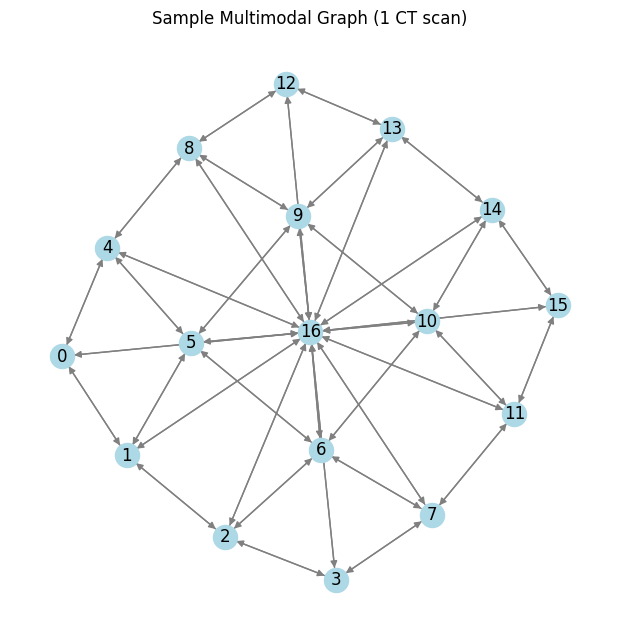

In [82]:
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

# Convert to NetworkX for visualization
G = to_networkx(data)

# Plot graph
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
plt.title("Sample Multimodal Graph (1 CT scan)")
plt.show()


# GNN Model

### GNN Model Definition

In [83]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv, global_max_pool

class GCNGraphClassifier(torch.nn.Module):
    def __init__(self, in_channels=512, hidden_channels=64, num_classes=4):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_max_pool(x, batch)
        return self.lin(x)


### Setup Model, Optimizer, and DataLoader

In [84]:
from sklearn.model_selection import train_test_split

# Extract true labels from the graph dataset
labels = [data.y.item() for data in graph_dataset]

# Perform a stratified train-test split
train_idx, test_idx = train_test_split(
    list(range(len(graph_dataset))),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Use these indices to select data
train_dataset = [graph_dataset[i] for i in train_idx]
test_dataset = [graph_dataset[i] for i in test_idx]

# Define data loaders
from torch_geometric.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


C:\Users\glori\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Training & Evaluation Functions

In [85]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)


## Evaluation

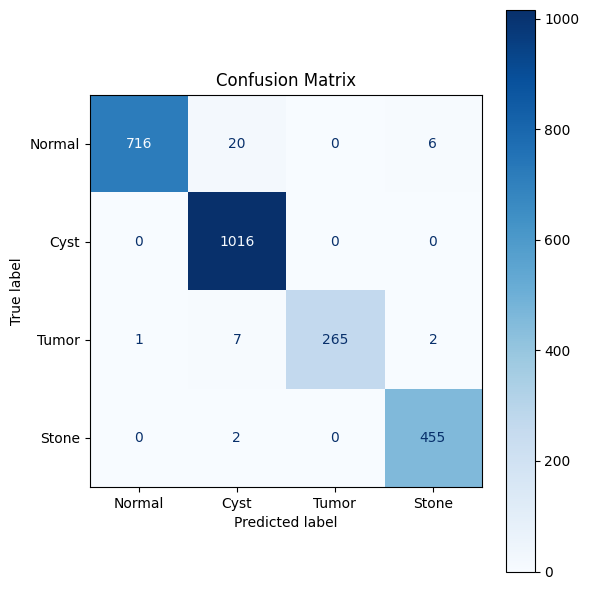

In [52]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in loader:
            out = model(batch.x, batch.edge_index, batch.batch)
            pred = out.argmax(dim=1)
            y_true.extend(batch.y.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

class_names = ['Normal', 'Cyst', 'Tumor', 'Stone']  # Adjust if needed
plot_confusion_matrix(model, test_loader, class_names)


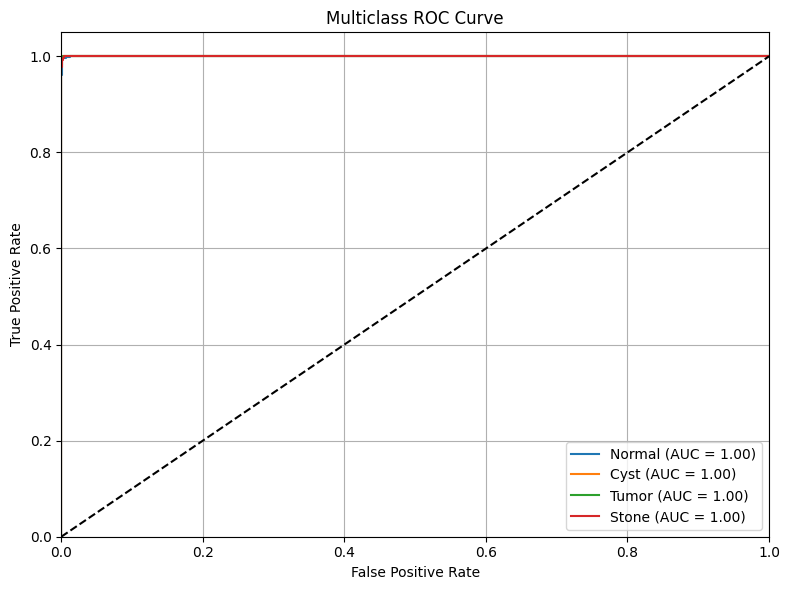

In [53]:
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np


class_names = ["Normal", "Cyst", "Tumor", "Stone"]
n_classes = len(class_names)

# Collect predictions and labels
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        probs = torch.softmax(out, dim=1).cpu().numpy()
        labels = data.y.cpu().numpy()

        all_probs.append(probs)
        all_labels.extend(labels)

# Convert to arrays
all_probs = np.vstack(all_probs)
all_labels = np.array(all_labels)

# Binarize labels for multiclass ROC
y_true_bin = label_binarize(all_labels, classes=np.arange(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


In [43]:
train_losses = []

for epoch in range(1, 11):
    loss = train()
    acc = test(test_loader)
    train_losses.append(loss)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Acc: {acc:.4f}")


Epoch 01 | Loss: 0.0183 | Test Acc: 0.9984
Epoch 02 | Loss: 0.0173 | Test Acc: 0.9739
Epoch 03 | Loss: 0.0021 | Test Acc: 1.0000
Epoch 04 | Loss: 0.0002 | Test Acc: 1.0000
Epoch 05 | Loss: 0.0202 | Test Acc: 0.9996
Epoch 06 | Loss: 0.0143 | Test Acc: 0.9992
Epoch 07 | Loss: 0.0010 | Test Acc: 1.0000
Epoch 08 | Loss: 0.0001 | Test Acc: 1.0000
Epoch 09 | Loss: 0.0001 | Test Acc: 1.0000
Epoch 10 | Loss: 0.0001 | Test Acc: 1.0000


In [89]:
for epoch in range(1, 2):
    loss = train()
    acc = test(test_loader)
    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Test Acc: {acc:.4f}")


Epoch 01 | Loss: 1.5450 | Test Acc: 0.1100


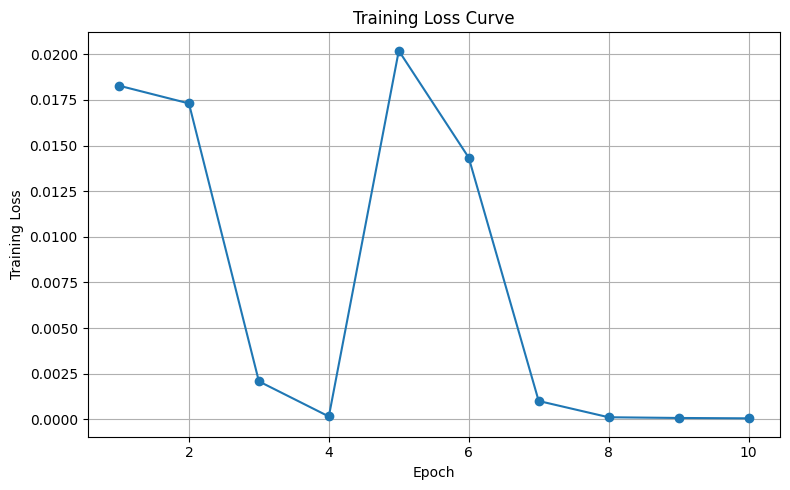

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.tight_layout()
plt.show()
